In [ ]:
# !pip install umap-learn

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

from sklearn import tree
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib import cm
import umap #for umap

sns.set()

In [2]:
def plot_decision_boundary(data,labels,clf):
    plot_step = 0.02
    x_min, x_max = data[:,0].min() -1, data[:,0].max() + 1
    y_min,y_max = data[:,1].min() -1 , data[:,1].max() + 1

    xx,yy = np.meshgrid(np.arange(x_min,x_max,plot_step),
                   np.arange(y_min,y_max,plot_step))
    A = np.array(clf.predict(np.c_[xx.ravel(),yy.ravel()]))
    A = A.reshape(xx.shape)
    cs = plt.contourf(xx,yy,A,cmap='cool')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Decision Boundary')

    plt.scatter(data[:,0],data[:,1],c=labels,cmap='hot',s=100)
    plt.show()

### Optimal Features from Bagging notebook

In [3]:
optim_feats = np.array(['fcf_yield', 'oiadpq', 'rd_saleq', 'market_cap', 'oancfy_q',
       'oeps12', 'ibadj12', 'book_value_yield', 'oepf12', 'quick_ratioq',
       'short_debtq', 'cf_yield', 'sic_6798', 'ibcy', 'xidoy', 'chechy',
       'inv_turnq', 'ocf_lctq', 'dpcq', 'cfmq', 'oancfy', 'roeq',
       'cfo-per-share', 'txpq', 'opmbdq', 'psq', 'dltisy', 'dltry',
       'yearly_sales', 'xsgay', 'lagppent4', 'fcf_ocfq', 'cash_ratioq',
       'de_ratioq', 'sale_equityq', 'evmq', 'opepsq', 'dvy', 'actq',
       'capxq', 'ceq4', 'fcf_csfhdq', 'sale_invcapq', 'apq', 'dlttq',
       'rect_actq', 'capeiq', 'nopiq', 'capxy', 'npmq', 'invt_actq',
       'oibdpy', 'accrualq', 'int_totdebtq', 'txtq', 'gpmq',
       'aftret_invcapxq', 'dpq'], dtype=object)

In [4]:
len(optim_feats)

58

**Only Include half of the features randomly**

In [5]:
max_features = 0.5
features = np.random.choice(optim_feats,int(0.5 * len(optim_feats)),replace=False)
features

array(['oancfy', 'dlttq', 'sale_invcapq', 'market_cap', 'npmq', 'evmq',
       'nopiq', 'txtq', 'oeps12', 'fcf_ocfq', 'actq', 'apq', 'fcf_yield',
       'cash_ratioq', 'roeq', 'chechy', 'opmbdq', 'xsgay',
       'book_value_yield', 'invt_actq', 'rect_actq', 'yearly_sales',
       'rd_saleq', 'capxy', 'dltisy', 'cf_yield', 'ibcy', 'ibadj12',
       'oiadpq'], dtype=object)

In [6]:
len(features)

29

## The RandomForest is an ensemble of Trees. Each Tree is built up of Nodes.

### Node Class

In [7]:
class Node():
        def __init__(self,data:pd.DataFrame = None,labels=None,min_samples_leaf = 1,max_features=0.5):
            self.data = data
            self.labels = labels
            self.left = None
            self.right = None
            self.split = None
            self.max_features = max_features
            self.min_samples_leaf = min_samples_leaf
            if len(self.data) < 2 * self.min_samples_leaf:
                self.isLeaf = True
            else: self.isLeaf = False
            
        def gini_index(self,labels):

            C = Counter(labels)
            total = len(labels)
            frequencies = { k:v/total for (k,v) in C.items()}
            gini_index = np.sum([p*(1-p) for p in frequencies.values()])
            #running loop in an array saves time
            return gini_index
        
        def find_best_split(self):
            
            if self.data.empty:
                return
            
            if len(self.data) < 2*self.min_samples_leaf:
                self.isLeaf = True
                return

        
            data_set = self.data.reset_index(drop=True)
            labels = self.labels
            
            
            if self.max_features * len(data_set.columns) <= 1:
                n=1
            else:
                n = np.random.choice(range(1,int(self.max_features * len(data_set.columns))+1),1)
 
            random_features = np.random.choice(data_set.columns,n,replace=False)

            best_split_gini = np.inf
        
            best_feature = None
            best_value = None
        
            for f in random_features:
           
                for x in data_set[f]:
                
                
                    L_idxs = data_set.index[data_set[f] < x].tolist()
                    R_idxs = data_set.index[data_set[f] >= x].tolist()


                    L_labels = labels[L_idxs]
                    R_labels = labels[R_idxs]
                    
                    if (len(L_labels) < self.min_samples_leaf) or (len(R_labels) < self.min_samples_leaf):
                        continue
                        
                    else:

                        gi_L = self.gini_index(L_labels)
                        gi_R = self.gini_index(R_labels)

                        gini_index_of_split = len(L_idxs) * gi_L + len(R_idxs) * gi_R
               
                        if gini_index_of_split < best_split_gini:
                            best_split_gini = gini_index_of_split
                        
                            self.left = Node(data=data_set.iloc[L_idxs].reset_index(drop=True),
                                             labels = L_labels,min_samples_leaf = self.min_samples_leaf)
                
                            if (gi_L == 0) or (len(L_labels) < 2 * self.min_samples_leaf):
                                    self.left.isLeaf = True

                

                            self.right = Node(data = data_set.iloc[R_idxs].reset_index(drop=True),
                                              labels = R_labels,min_samples_leaf = self.min_samples_leaf)
                    
                            if (gi_R == 0) or (len(R_labels) < 2 * self.min_samples_leaf):
                                       self.right.isLeaf = True

                                
                            best_feature = f
                            best_value = x
                        
                            self.split = (best_feature,best_value)
                                
                        else: continue
  
                return
                                

## A data set with 4 features and 4 labels

In [8]:
from sklearn.datasets import make_classification

In [9]:
X, y = make_classification(n_samples=500,n_features=4, n_redundant=0, n_informative=2,
                             n_clusters_per_class=1, n_classes=4)

In [10]:
reducer = umap.UMAP()

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
X_embedded = reducer.fit_transform(X)

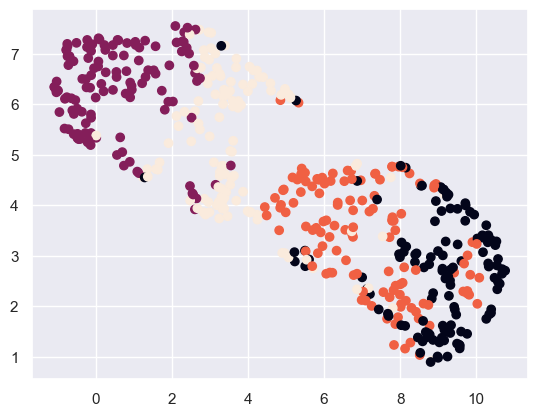

In [13]:
plt.scatter(X_embedded[:,0],X_embedded[:,1],c=y);

In [ ]:
y

In [14]:
X = pd.DataFrame(data = X, columns = [0,1,2,3])

In [ ]:
X

In [15]:
from collections import Counter
C = Counter(y)
C

Counter({2: 126, 3: 125, 1: 125, 0: 124})

In [16]:
C.most_common()

[(2, 126), (3, 125), (1, 125), (0, 124)]

In [17]:
C.most_common()[0][0]

2

In [18]:
total = len(y)

In [19]:
total

500

In [20]:
C.items()

dict_items([(2, 126), (3, 125), (0, 124), (1, 125)])

In [21]:
frequencies = { k:v/total for (k,v) in C.items()}
frequencies

{2: 0.252, 3: 0.25, 0: 0.248, 1: 0.25}

In [22]:
frequencies.values()

dict_values([0.252, 0.25, 0.248, 0.25])

In [23]:
gini_index = np.sum([ p * (1 - p) for p in frequencies.values()])
gini_index

0.749992

In [24]:
data_set = X
labels = y

In [25]:
max_features = 0.5
features = np.random.choice(data_set.columns,int(0.5 * len(data_set.columns)),replace=False)
features

array([1, 0], dtype=int64)

In [26]:
data_set[features]

,1,0
0,0.595112,0.049394
1,-0.593857,0.054356
2,0.728556,-0.469593
3,-1.029016,-2.171544
4,-0.895415,-0.390617
...,...,...
495,1.287201,-1.819151
496,0.048390,1.710399
497,1.481323,-0.129125
498,-0.613085,0.845011


In [27]:
f = 3
x = data_set[f].iloc[498]
x

0.953809432914698

In [28]:
L_idxs = data_set.index[data_set[f] < x].tolist()
R_idxs = data_set.index[data_set[f] >= x].tolist()

In [29]:
L_idxs

[0,
 2,
 3,
 4,
 5,
 6,
 7,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 18,
 19,
 20,
 21,
 22,
 23,
 25,
 26,
 27,
 28,
 29,
 30,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 40,
 41,
 43,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 53,
 55,
 56,
 59,
 60,
 61,
 62,
 63,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 77,
 78,
 79,
 80,
 82,
 83,
 85,
 86,
 87,
 88,
 89,
 91,
 92,
 95,
 98,
 99,
 100,
 101,
 103,
 106,
 109,
 110,
 111,
 112,
 113,
 116,
 117,
 119,
 120,
 121,
 122,
 123,
 124,
 126,
 129,
 130,
 132,
 133,
 135,
 136,
 137,
 138,
 139,
 143,
 144,
 145,
 147,
 148,
 149,
 150,
 151,
 153,
 154,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 172,
 173,
 174,
 175,
 176,
 177,
 179,
 181,
 182,
 183,
 185,
 186,
 188,
 189,
 190,
 191,
 194,
 195,
 197,
 198,
 199,
 200,
 201,
 202,
 203,
 204,
 205,
 208,
 209,
 210,
 213,
 214,
 215,
 216,
 217,
 218,
 219,
 220,
 221,
 222,
 223,
 224,
 225,
 227,
 228,
 229,
 230,
 234,
 235,
 236,
 237,


In [30]:
R_idxs

[1,
 8,
 16,
 17,
 24,
 31,
 39,
 42,
 44,
 52,
 54,
 57,
 58,
 64,
 76,
 81,
 84,
 90,
 93,
 94,
 96,
 97,
 102,
 104,
 105,
 107,
 108,
 114,
 115,
 118,
 125,
 127,
 128,
 131,
 134,
 140,
 141,
 142,
 146,
 152,
 155,
 171,
 178,
 180,
 184,
 187,
 192,
 193,
 196,
 206,
 207,
 211,
 212,
 226,
 231,
 232,
 233,
 239,
 242,
 248,
 249,
 253,
 255,
 256,
 259,
 272,
 277,
 279,
 280,
 281,
 284,
 286,
 288,
 290,
 292,
 293,
 295,
 296,
 297,
 298,
 300,
 301,
 303,
 304,
 307,
 315,
 316,
 317,
 318,
 322,
 327,
 328,
 329,
 330,
 333,
 336,
 339,
 344,
 345,
 347,
 349,
 354,
 361,
 362,
 363,
 369,
 371,
 377,
 383,
 384,
 385,
 387,
 388,
 391,
 394,
 399,
 400,
 401,
 403,
 412,
 420,
 427,
 429,
 431,
 433,
 449,
 457,
 460,
 463,
 468,
 469,
 479,
 491,
 497,
 498]

In [31]:
L_labels = labels[L_idxs]
R_labels = labels[R_idxs]

In [32]:
def gini_index(labels):

            C = Counter(labels)
            total = len(labels)
            frequencies = { k:v/total for (k,v) in C.items()}
            gini_index = np.sum([p*(1-p) for p in frequencies.values()])
            return gini_index

In [33]:
print(gini_index(L_labels))
print(gini_index(R_labels))
      

0.7177781947832614
0.514567901234568


In [34]:
gini_index_of_split = (len(L_labels)*gini_index(L_labels) + len(R_labels)*gini_index(R_labels))/len(data_set)
print(gini_index_of_split)

0.6629114155251142


In [37]:
root = Node(X,y)

In [38]:
root.find_best_split()

In [39]:
root.left.data

,0,1,2,3
0,0.049394,0.595112,-0.532922,-1.850891
1,-2.171544,-1.029016,-1.227838,0.936005
2,1.487058,-0.237961,-1.474076,-1.315369
3,-1.475738,0.720018,-0.253985,-0.443309
4,-2.208001,-0.612180,-0.045651,-1.677388
...,...,...,...,...
279,-1.591623,-1.698114,-0.472407,-0.982913
280,1.509388,0.429420,-0.460095,-1.997120
281,-0.855635,0.391552,-1.662993,-1.046916
282,-0.129125,1.481323,-0.744579,1.169140


In [40]:
root.labels

array([2, 3, 0, 1, 3, 0, 3, 2, 3, 2, 1, 2, 2, 2, 0, 0, 1, 3, 1, 2, 3, 1,
       2, 0, 1, 0, 2, 0, 2, 2, 3, 3, 1, 0, 0, 2, 2, 0, 0, 3, 2, 1, 3, 1,
       3, 2, 1, 0, 2, 2, 0, 2, 3, 1, 3, 3, 0, 1, 3, 0, 2, 0, 0, 1, 1, 3,
       0, 1, 2, 2, 2, 0, 2, 0, 3, 2, 1, 2, 0, 3, 0, 1, 2, 2, 3, 0, 1, 2,
       2, 1, 3, 0, 2, 3, 3, 3, 1, 1, 0, 0, 3, 0, 3, 1, 1, 1, 2, 1, 1, 0,
       1, 1, 0, 0, 3, 3, 1, 2, 3, 0, 2, 2, 2, 2, 0, 1, 3, 1, 3, 3, 2, 1,
       2, 2, 3, 0, 0, 2, 3, 3, 1, 1, 1, 3, 0, 3, 1, 0, 2, 0, 2, 1, 3, 1,
       1, 3, 3, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 3, 1, 2, 1, 2, 3, 0, 2,
       0, 2, 3, 0, 1, 0, 1, 1, 1, 2, 0, 3, 2, 1, 0, 2, 3, 1, 3, 2, 3, 2,
       0, 0, 2, 1, 2, 0, 0, 2, 2, 3, 0, 3, 0, 3, 3, 3, 0, 3, 2, 2, 2, 1,
       1, 0, 1, 3, 3, 1, 3, 2, 1, 2, 2, 3, 1, 1, 1, 0, 2, 0, 2, 3, 1, 1,
       1, 0, 3, 0, 2, 3, 3, 1, 0, 0, 1, 1, 0, 1, 3, 2, 0, 3, 1, 3, 1, 2,
       0, 2, 0, 0, 2, 3, 0, 1, 3, 1, 0, 2, 2, 1, 2, 1, 3, 3, 0, 2, 3, 0,
       1, 0, 3, 2, 3, 0, 1, 1, 0, 1, 3, 1, 1, 2, 3,

In [41]:
root.split

(2, 0.2465509502371508)

### Tree class

In [35]:
class Tree():
    
    def __init__(self,root:Node,max_depth = np.inf,min_samples_leaf=1):
        self.root = root
        self.levels = [[self.root]]
        self.max_depth = max_depth
        self.splits = []
        self.min_samples_leaf = min_samples_leaf
        self.root.min_samples_leaf = self.min_samples_leaf
        
        self.build_tree()
        
        
    def build_tree(self):
        
                while np.any([((n != None) and (not n.isLeaf)) for n in self.levels[-1]]) and (len(self.levels) < self.max_depth):
                    
                    level = []
                    
                    for node in [n for n in self.levels[-1] if ((n != None) and (not n.isLeaf))]:

                        if (node != None) and (not node.isLeaf):

                            node.find_best_split()
                            level.append(node.left)
                            level.append(node.right)
                            self.splits.append(node.split)
                        
                        else: continue
                            
                    if (len(level)==0):
                            return
                    else:
                            self.levels.append(level) 

        
    def predict(self,x):
                      
        idx = 0
        depth = len(self.levels)
        
        val = Counter(self.root.labels).most_common()[0][0]
        
        
        
        for i in range(depth):

                node = self.levels[i][idx]

                if (node.split != None):
                
                    s = node.split
                    
  
                    if (x[s[0]] < s[1]):
#                         if node.left in self.nodes[i+1]:
                            idx = self.levels[i+1].index(node.left)
                            val = Counter(node.left.labels).most_common()[0][0]
                    
                    else:
#                         if node.right in self.nodes[i+1]:
                                idx = self.levels[i+1].index(node.right)                         
                                val = Counter(node.right.labels).most_common()[0][0]  
                            
                else: return val
                
        return val


                       


## Applying the Tree to the make_classification data set

In [42]:
tree = Tree(root)

In [43]:
len(tree.levels)

16

In [44]:
len(tree.levels[8])

40

In [45]:
tree.levels[8][9].isLeaf

False

In [46]:
tree.levels

[[<__main__.Node at 0x28bf1395890>],
 [<__main__.Node at 0x28bf36eb290>, <__main__.Node at 0x28bf14464d0>],

In [47]:
tree.splits

[(2, 0.2465509502371508),
 (0, 0.9687147539194852),
 (2, 2.2996630826729687),
 (0, 0.21730425448491084),
 (1, -0.23796069499174927),
 (0, 0.9319720864048122),
 (1, -0.7680130843712762),
 (2, -0.6991537515031667),
 (1, -1.62095807138373),
 (2, -0.02368894592226145),
 (0, 1.1984755154009825),
 (2, 0.25931453728582765),
 (0, 1.2297715630819177),
 (1, -0.8196332489979319),
 (3, 1.6639366619872655),
 (1, 1.4531898890601753),
 (2, -0.5904373135049211),
 (1, -0.058132435000528095),
 (3, 0.39046425449857025),
 (0, 1.5805699067906063),
 (0, 1.1269891138391692),
 (0, 1.5919709787338958),
 (1, 2.1037061683485674),
 (0, 0.9873901412944132),
 (0, 1.688229350401455),
 (1, -0.7193818472729827),
 (3, 0.5088095280426599),
 (1, 0.7942449976518312),
 (2, -0.09630548049588805),
 (1, 0.5119404326598391),
 (3, 0.821505332516027),
 (0, 1.2896994735135154),
 (0, 1.914188908848222),
 (1, -1.5017733146642565),
 (3, 2.0701910645210013),
 (1, -0.08809296088804665),
 (3, -0.7247856272090827),
 (2, 1.67937231456569

In [48]:
tree.levels[8][0].isLeaf

True

In [49]:
x = X.iloc[30].values

In [50]:
x

array([ 0.33565959, -1.54591243,  0.73868113, -0.07345774])

In [51]:
tree.predict(x)

3

In [52]:
y[30]

3

### RandomForestClassifier class

In [53]:
class RandomForestClassifier():
    
    def __init__(self,n_estimators=10,max_features=1.0,min_samples_leaf=1,bootstrap=False,max_depth = np.inf,
                 random_state=None):
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.min_samples_leaf = min_samples_leaf
        self.max_depth = max_depth
        self.bootstrap = bootstrap
        if random_state is not None:
            np.random.seed(random_state)
        self.trees = []  
        
    def fit(self,data,labels):
        
        N = len(labels)
        
        for i in range(self.n_estimators):
            if self.bootstrap:
                idxs = np.random.choice(range(N),N)
                data_set = data.iloc[idxs]
                label_set = labels[idxs]
            else:
                data_set = data
                label_set = labels
                
            root = Node(data_set,label_set)
            root.max_features = self.max_features
            t = Tree(root,self.max_depth,self.min_samples_leaf)
            
            self.trees.append(t)
            
    def predict(self,data_points):
            
            if len(self.trees) == 0:
                print('Classifier needs to be fitted')
                return
            
            if type(data_points) == pd.DataFrame:
                data_points = data_points.values
            
            preds = []
            for x in data_points:

                x_preds = []
                for t in self.trees:
                    x_preds.append(t.predict(x))
                    
                preds.append(Counter(x_preds).most_common()[0][0])
                
            return preds
                
                
        
            
    

In [54]:
from sklearn.model_selection import train_test_split

In [55]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

In [56]:
rf_clf = RandomForestClassifier(n_estimators=40,bootstrap=True,max_depth=4,max_features=0.5)

In [57]:
rf_clf.fit(X_train,y_train)

In [58]:
preds = rf_clf.predict(X_test)

In [60]:
from sklearn.metrics import accuracy_score

In [61]:
accuracy_score(y_test,preds)

0.69

## Data set with 2 features and 4 labels

In [62]:
Z, u = make_classification(n_features=2, n_redundant=0, n_informative=2,
                             n_clusters_per_class=1, n_classes=4)

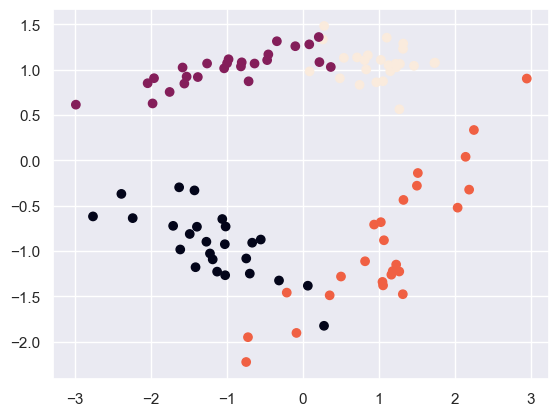

In [63]:
plt.scatter(Z[:,0],Z[:,1],c=u);

In [64]:
Z = pd.DataFrame(data = Z, columns = [0,1])

In [65]:
print(Z)

           0         1
0   0.812487  1.103855
1  -1.271290 -0.898880
2  -1.017977 -0.730959
3   1.501318 -0.280840
4  -2.390920 -0.371140
..       ...       ...
95 -0.342879  1.312584
96  1.227982  1.025067
97 -1.561512  0.845420
98  0.539276  1.129099
99 -0.746465 -1.083400

[100 rows x 2 columns]


## RandomForestClassifier applied to the 2-dim make_classification data set

In [66]:
rf_clf = RandomForestClassifier(n_estimators=15,max_features=0.4)

In [67]:
rf_clf.fit(Z,u)

In [68]:
pred = rf_clf.predict(Z)

In [69]:
data = Z.values

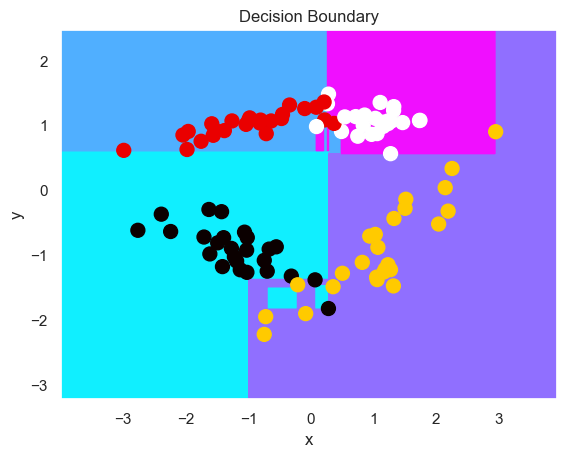

In [70]:
plot_decision_boundary(data,u,rf_clf)

In [71]:
accuracy_score(u,pred)

1.0

In [72]:
len(u[u == pred])/len(Z)

1.0

In [73]:
rf_clf = RandomForestClassifier(n_estimators=100,bootstrap=True,max_features=0.5,random_state=123)

In [74]:
rf_clf.fit(Z,u)

In [75]:
preds = rf_clf.predict(Z.values)

In [76]:
accuracy_score(u,preds)

1.0

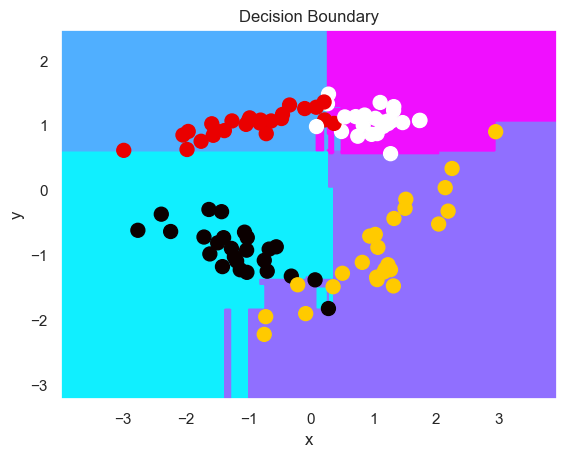

In [77]:
plot_decision_boundary(Z.values,u,rf_clf)

In [78]:
Z_train,Z_test,u_train,u_test = train_test_split(Z,u,test_size=0.2)

In [79]:
rf_clf.fit(Z_train,u_train)

In [81]:
test_pred = rf_clf.predict(Z_test)

In [83]:
accuracy_score(test_pred,u_test)

1.0

## sklearn RandomForestClassifier

In [84]:
from sklearn.ensemble import RandomForestClassifier

In [85]:
rf_clf = RandomForestClassifier(n_estimators=100,bootstrap=True,max_depth=7,max_features=0.5,min_samples_leaf=10)

In [86]:
rf_clf.fit(X_train,y_train)

RandomForestClassifier(max_depth=7, max_features=0.5, min_samples_leaf=10)

In [87]:
preds = rf_clf.predict(X_test)

In [88]:
accuracy_score(y_test,preds)

0.76